# Tuning of Hyperparameters in Simple Self-EFficacy Learner Model

This notebook includes code from iterating on the Self-Efficacy Learner Behavior Model including hyperparameters for generating the set of learners in the population.

In [1]:
import sys
sys.path.append("../")

In [2]:
import logging
import random
import uuid
import os
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tutor.domain import Domain
from tutor.cogtutor_curriculum import CogTutorCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest
from learner.selfeff_learner import SelfEfficacyLearner


from simulate.self_eff_simulation import SelfEffSimulation
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper


In [4]:
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

In [5]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [6]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.debug("Base directory for the project:\n%s" % base_dir)

In [7]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:main:Writing simulation results to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-e394166e-6449-43b3-bdfa-069256990859
INFO:main:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [8]:
logger.info("Clearing database before starting new simulation")
db_util.clear_db()

INFO:main:Clearing database before starting new simulation


## Generating Learners

### Setting up Simulation

In [9]:
# Generating empty domain
domain = Domain()
domain_params = {
    'm_l0': 0.45,
    'sd_l0': 0.155,
    'm_t': 0.45,
    'sd_t': 0.13,#0.03,
    'm_s': 0.155,
    'sd_s': 0.055,
    'm_g': 0.45,#0.6,
    'sd_g': 0.105 
}
domain.set_kc_hyperparams(**domain_params)

In [10]:
# Generating the Curriculum and domain together

curric = CogTutorCurriculum(domain)
curric.generate(num_units=30,
               mean_sections=4,
               stdev_sections=2,
               mean_unit_kcs=22,
               stdev_unit_kcs=23,
               section_kcs_lambda=6,
               mean_steps=10,
               stdev_steps=4,
               mean_prob_kcs=6,
               stdev_prob_kcs=3,
               num_practice=400)


INFO:tutor.cogtutor_curriculum:Generated 30 units with with a total of 777 kcs


In [11]:
# Insert domain to db
db.domains.insert_one(domain.to_dict())
db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])

# Insert Curriculum to db
curric_util = DB_Curriculum_Mapper(db_params)
curric_util.write_to_db(curric)

INFO:log_db.curriculum_mapper:Writing curriculum with id, 50c7162d-e4a0-498f-9e87-e938b3f42520, to db
INFO:log_db.curriculum_mapper:Writing 83619 problem to db
INFO:log_db.curriculum_mapper:Writing 338584 steps to db


### Initializing Learners

In [12]:
num_students = 30
students = [SelfEfficacyLearner(domain) for i in range(num_students)]
logger.info("Sample student:\n%s" % str(students[0]))
logger.info("Inserting %i students to db" % len(students))
result = db.students.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Sample student:
INFO:main:Inserting 30 students to db
INFO:main:Db insert success: True


### Simulating Learners

In [13]:
for i, stu in enumerate(students):
    logger.info("Simulating student #%i" % i)
    sim = SelfEffSimulation(domain, curric, stu)
    sim.run()

INFO:main:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #2
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #3
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active sess

In [14]:
logger.info("Inserting %i simulated students to db" % len(students))
db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Inserting 30 simulated students to db
INFO:main:Db insert success: True


In [15]:
#db_util.dump_db()

## EDA of simulated Data

In [16]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, finalsimstudents, has 30 documents
INFO:log_db.mongo:collection name, curriculum, has 0 documents
INFO:log_db.mongo:collection name, sections, has 126 documents
INFO:log_db.mongo:collection name, problems, has 83619 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, units, has 30 documents
INFO:log_db.mongo:collection name, decisions, has 479747 documents
INFO:log_db.mongo:collection name, actions, has 479747 documents
INFO:log_db.mongo:collection name, students, has 30 documents
INFO:log_db.mongo:collection name, tutor_events, has 421871 documents
INFO:log_db.mongo:collection name, steps, has 338584 documents
INFO:log_db.mongo:collection name, kcs, has 777 documents
INFO:log_db.mongo:collection name, domains, has 1 documents


In [17]:
# look at number of students in tutor_events
#tx = pd.DataFrame([evt for evt in db['tutor_events'].find({'type': "Tutor Input"})])
#logger.info(tx.shape)
#logger.info(tx.groupby('stu_id')['_id'].count())

### Domain & Cirriculum EDA

In [18]:
'''
For recovering curriculum from db if running this script 
without newly generated curriculum

''' 


#result = db.curriculums.find()
#curriculums = [c for c in result]
#print(len(curriculums))
#cid = curriculums[0]['_id']
#curric_d = curriculums[0]
#print("curriculum id: %s" % cid)

'\nFor recovering curriculum from db if running this script \nwithout newly generated curriculum\n\n'

In [19]:
#curric_util = DB_Curriculum_Mapper(db_params)
#curric = curric_util.get_from_db(cid)
#print(str(curric))

In [20]:
kc_counts = []
prob_counts = []
for j, unit in enumerate(curric.units):
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("Unit #%i" % j)
    for i, section in enumerate(unit.sections):
        logger.info("##########################################")
        logger.info("Section #%i: %s" % (i, section._id))
        logger.info("Number of kcs: %i" % len(section.kcs))
        kc_counts.append(len(section.kcs))
        logger.info("Number of Problems: %i" % len(section.problems))
        prob_counts.append(len(section.problems))
        step_counts = [len(prob.steps) for prob in section.problems]
        
        step_dist = {val: step_counts.count(val) for val in set(step_counts)}
        logger.info("Distribution of steps across problems: %s" % str(step_dist))
    
kc_dist = {val: kc_counts.count(val) for val in set(kc_counts)}
prob_dist = {val: prob_counts.count(val) for val in set(prob_counts)}
logger.info("------------------- Total Curric stats --------------------------")
logger.info("Distribution of kcs per section: %s" % str(kc_dist))
logger.info("Distribution of prob per section: %s" % str(prob_dist))

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #0
INFO:main:##########################################
INFO:main:Section #0: 2e1bf960-3e89-460e-98f9-fd0581210cd7
INFO:main:Number of kcs: 11
INFO:main:Number of Problems: 1283
INFO:main:Distribution of steps across problems: {1: 150, 2: 174, 3: 218, 4: 245, 5: 222, 6: 136, 7: 90, 8: 32, 9: 15, 10: 1}
INFO:main:##########################################
INFO:main:Section #1: 2d671441-3d28-4d72-a4fc-f51482bca276
INFO:main:Number of kcs: 1
INFO:main:Number of Problems: 108
INFO:main:Distribution of steps across problems: {1: 12, 2: 17, 3: 17, 4: 27, 5: 19, 6: 11, 7: 3, 8: 2}
INFO:main:##########################################
INFO:main:Section #2: ba581ec0-66cc-4288-bc2f-ea0e5dcdfae5
INFO:main:Number of kcs: 1
INFO:main:Number of Problems: 101
INFO:main:Distribution of steps across problems: {1: 7, 2: 13, 3: 26, 4: 19, 5: 16, 6: 11, 7: 5, 8: 3, 9: 1}
INFO:main:$$$$$$

INFO:main:Number of Problems: 204
INFO:main:Distribution of steps across problems: {1: 23, 2: 21, 3: 34, 4: 42, 5: 43, 6: 23, 7: 13, 8: 4, 10: 1}
INFO:main:##########################################
INFO:main:Section #1: cd6efd7d-43f6-4e81-b4b7-34e4ef2b4be5
INFO:main:Number of kcs: 2
INFO:main:Number of Problems: 201
INFO:main:Distribution of steps across problems: {1: 24, 2: 16, 3: 36, 4: 40, 5: 41, 6: 30, 7: 11, 8: 2, 9: 1}
INFO:main:##########################################
INFO:main:Section #2: ca50d768-bd91-419b-b0a6-7082144c5b25
INFO:main:Number of kcs: 4
INFO:main:Number of Problems: 409
INFO:main:Distribution of steps across problems: {1: 44, 2: 53, 3: 67, 4: 83, 5: 59, 6: 53, 7: 35, 8: 7, 9: 6, 10: 2}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #9
INFO:main:##########################################
INFO:main:Section #0: 1dac8f64-b158-48ec-a9b2-0325fef2e40d
INFO:main:Number of kcs: 1
INFO:main:Number

INFO:main:Distribution of steps across problems: {1: 57, 2: 72, 3: 95, 4: 102, 5: 92, 6: 77, 7: 30, 8: 12, 9: 7, 10: 1}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #14
INFO:main:##########################################
INFO:main:Section #0: 3b01858c-40a3-4891-876e-4a9185209b73
INFO:main:Number of kcs: 7
INFO:main:Number of Problems: 738
INFO:main:Distribution of steps across problems: {1: 79, 2: 90, 3: 129, 4: 152, 5: 126, 6: 91, 7: 43, 8: 17, 9: 8, 10: 3}
INFO:main:##########################################
INFO:main:Section #1: a26d055e-04a8-4893-847c-d30bf7eefa6f
INFO:main:Number of kcs: 2
INFO:main:Number of Problems: 204
INFO:main:Distribution of steps across problems: {1: 28, 2: 26, 3: 25, 4: 42, 5: 39, 6: 24, 7: 11, 8: 6, 9: 1, 10: 2}
INFO:main:##########################################
INFO:main:Section #2: 84eebac9-02f1-4ecc-a82a-0f2e1a8b36b6
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 

INFO:main:Section #1: c72e4cc7-76b9-4b1d-99f7-c1ae3b1861ae
INFO:main:Number of kcs: 4
INFO:main:Number of Problems: 388
INFO:main:Distribution of steps across problems: {1: 28, 2: 50, 3: 68, 4: 78, 5: 73, 6: 42, 7: 31, 8: 15, 9: 1, 10: 1, 11: 1}
INFO:main:##########################################
INFO:main:Section #2: adb367db-6220-4b38-9613-163d48bd918c
INFO:main:Number of kcs: 23
INFO:main:Number of Problems: 2581
INFO:main:Distribution of steps across problems: {1: 277, 2: 323, 3: 454, 4: 513, 5: 438, 6: 311, 7: 168, 8: 64, 9: 28, 10: 5}
INFO:main:##########################################
INFO:main:Section #3: 60acf104-2751-4e54-8a0b-6a9796178b56
INFO:main:Number of kcs: 1
INFO:main:Number of Problems: 96
INFO:main:Distribution of steps across problems: {1: 12, 2: 12, 3: 11, 4: 17, 5: 16, 6: 15, 7: 11, 8: 1, 10: 1}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #20
INFO:main:#################################

INFO:main:Number of Problems: 1835
INFO:main:Distribution of steps across problems: {1: 171, 2: 219, 3: 328, 4: 358, 5: 331, 6: 219, 7: 121, 8: 70, 9: 11, 10: 7}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #26
INFO:main:##########################################
INFO:main:Section #0: c443e8f4-3730-488e-b0dc-e3c2967306d0
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 309
INFO:main:Distribution of steps across problems: {1: 32, 2: 46, 3: 51, 4: 61, 5: 42, 6: 46, 7: 23, 8: 6, 9: 2}
INFO:main:##########################################
INFO:main:Section #1: 9ac22737-d3fb-4189-8b23-1409680d73f8
INFO:main:Number of kcs: 1
INFO:main:Number of Problems: 95
INFO:main:Distribution of steps across problems: {1: 9, 2: 11, 3: 14, 4: 20, 5: 14, 6: 18, 7: 5, 8: 2, 9: 2}
INFO:main:##########################################
INFO:main:Section #2: affc5c39-a077-4ef7-b331-645f184f9e04
INFO:main:Number of kcs: 43
INFO:mai

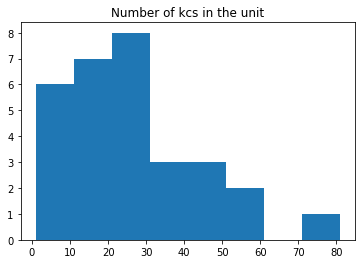

INFO:main:Total number of kcs: 777
INFO:main:count    30.000000
mean     25.900000
std      18.259339
min       1.000000
25%      13.250000
50%      23.000000
75%      36.000000
max      81.000000
dtype: float64


In [21]:
# Unit EDA
unit_kcs = [len(unit.kcs) for unit in curric.units]
plt.hist(unit_kcs, bins=8)
plt.title("Number of kcs in the unit")
plt.show()
logger.info("Total number of kcs: %i" % np.sum(unit_kcs))
logger.info(pd.Series(unit_kcs).describe())

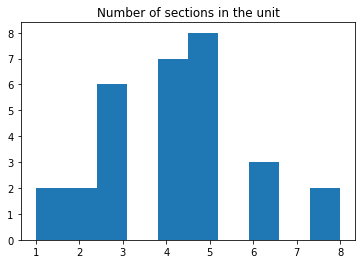

INFO:main:Total number of sections: 126
INFO:main:count    30.000000
mean      4.200000
std       1.689726
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       8.000000
dtype: float64


In [22]:
#Section EDA
unit_sections = [len(unit.sections) for unit in curric.units]
plt.hist(unit_sections, bins=10)
plt.title("Number of sections in the unit")
plt.show()
logger.info("Total number of sections: %i" % np.sum(unit_sections))
logger.info(pd.Series(unit_sections).describe())

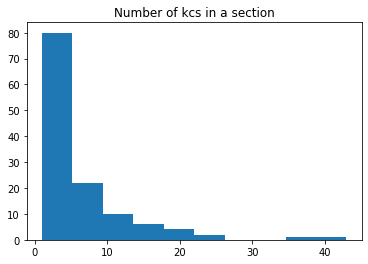

INFO:main:count    126.000000
mean       6.166667
std        6.799706
min        1.000000
25%        2.000000
50%        4.000000
75%        8.000000
max       43.000000
dtype: float64


In [23]:
section_kcs = []
for unit in curric.units:
    section_kcs.extend([len(section.kcs) for section in unit.sections])
plt.hist(section_kcs, bins=10)
plt.title("Number of kcs in a section")
plt.show()
logger.info(pd.Series(section_kcs).describe())

INFO:main:Distribution of steps per problems: 
1      8830.0
2     10167.0
3     14794.0
4     16290.0
5     14655.0
6     10146.0
7      5484.0
8      2257.0
9       732.0
10      218.0
11       39.0
12        5.0
13        2.0
dtype: float64


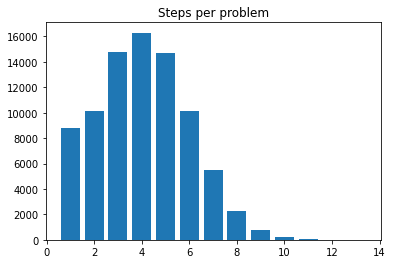

In [24]:
# steps per problem EDA
step_counts = []
for unit in curric.units:
    for section in unit.sections:
 #       logger.info("Section with %i kcs and %i problems" % (len(section.kcs), len(section.problems)))
        counts = pd.Series([len(prob.steps) for prob in section.problems]).value_counts()
#        logger.info("Counts of steps per problems \n%s" % str(counts))
        step_counts.append(counts)

    
prob_steps = pd.DataFrame(step_counts).sum(axis=0)
logger.info("Distribution of steps per problems: \n%s" %  str(prob_steps))
plt.bar(prob_steps.index, prob_steps)
plt.title("Steps per problem")
plt.show()

### Student EDA

In [25]:
logger.info("Getting pre-sim students")
presim_students = pd.DataFrame(db.students.find())
sim_students = pd.DataFrame(db.finalsimstudents.find())
sim_students.rename(columns={'skills': 'final skills', 
                             'total_attempts': 'final total attempts',
                             'total_success': 'final total success'}, inplace=True)

logger.info("pre-sim students: %s" % str(presim_students.shape))
logger.info("post-sim students: %s" % str(sim_students.shape))


sim_students = presim_students.merge(sim_students[['_id', 'final skills', 'final total attempts', 'final total success']], how='right', on=['_id'])
sim_students['pre-sim total mastery'] = sim_students.apply(lambda x: np.sum(list(x['skills'].values())), axis=1)
sim_students['final-sim total mastery'] = sim_students.apply(lambda x: np.sum(list(x['final skills'].values())), axis=1)
sim_students['total skills'] = sim_students.apply(lambda x: len(list(x['skills'].values())), axis=1)
sim_students['pre-sim pct mastery'] = sim_students.apply(lambda x: x['pre-sim total mastery'] / x['total skills'], axis=1)
sim_students['final-sim pct mastery'] = sim_students.apply(lambda x: x['final-sim total mastery'] / x['total skills'], axis=1)
sim_students['final-sim total unmastered'] = sim_students.apply(lambda x: x['total skills'] - x['final-sim total mastery'], axis=1)
sim_students['final self-eff'] = sim_students.apply(lambda x: ((x['self_eff'] * 100) + x['final total success']) / (500 + x['final total attempts']), axis=1)
sim_students['pct success'] = sim_students.apply(lambda x: x['final total success'] / x['final total attempts'], axis=1)
sim_students.head()

INFO:main:Getting pre-sim students
INFO:main:pre-sim students: (30, 13)
INFO:main:post-sim students: (30, 13)


,_id,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,diligence,self_eff,...,final total attempts,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,final self-eff,pct success
0,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,"{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': True,...",30,1200,3,1,2.107698,0.288104,...,9650,6908,340,772,777,0.437580,0.993565,5,0.683430,0.715855
1,327ad706-e622-4654-971c-667b03286091,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,"{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': True,...",30,1200,3,1,2.339970,0.456831,...,11083,8165,361,773,777,0.464607,0.994852,4,0.708856,0.736714
2,df529b19-c107-4b83-842c-327aaf5d766a,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,"{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': True,...",30,1200,3,1,2.135348,0.524265,...,9463,6909,363,773,777,0.467181,0.994852,4,0.698728,0.730107
3,0493f231-fcf9-4ade-9a81-5ad3994f7054,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': False...,30,1200,3,1,2.537093,0.769449,...,9349,7045,333,774,777,0.428571,0.996139,3,0.723114,0.753557
4,8ef3af58-d9f2-49cd-b5b3-472bb5b1c2f7,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': False...,30,1200,3,1,2.739164,0.508867,...,8591,6301,373,766,777,0.480051,0.985843,11,0.698701,0.733442


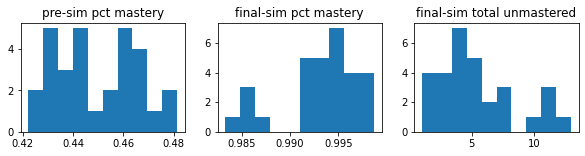

INFO:main:Total skills: 777


In [26]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


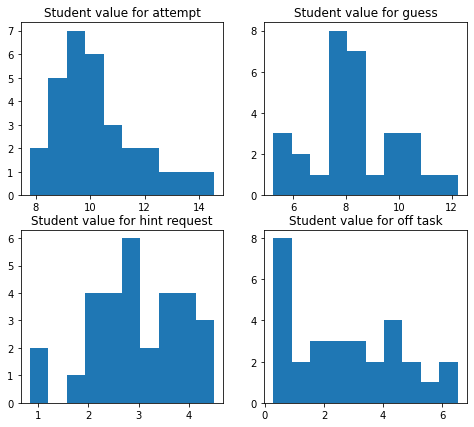

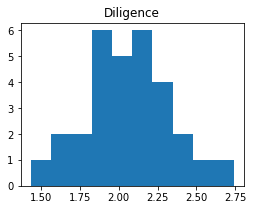

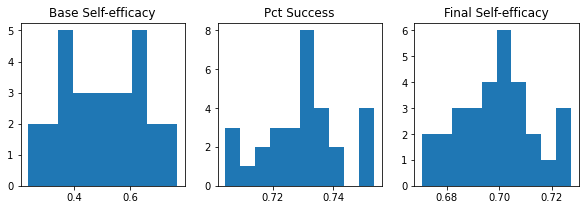

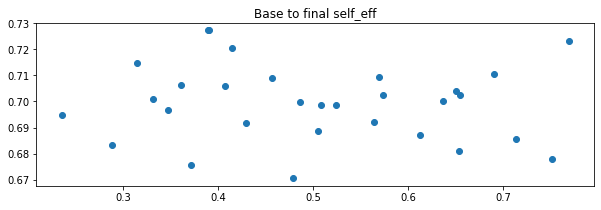

In [27]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(sim_students['self_eff'], bins=10)
plt.title("Base Self-efficacy")
plt.subplot(1,3,2)
plt.hist(sim_students['pct success'], bins=10)
plt.title("Pct Success")
plt.subplot(1,3,3)
plt.hist(sim_students['final self-eff'], bins=10)
plt.title("Final Self-efficacy")
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(sim_students['self_eff'], sim_students['final self-eff'])
plt.title("Base to final self_eff")
plt.show()



### Learner Actions EDA

In [28]:
# Get Learner actions
actions = pd.DataFrame(db.actions.find())
actions['type'] = actions.apply(lambda x: x['action']['name'], axis=1)
actions['duration'] = actions.apply(lambda x: x['action']['time'], axis=1)
actions.head()

,_id,student_id,action,time,type,duration
0,03c52a99-b891-4776-95b9-769d75867ee0,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,"{'name': 'Hint Request', 'time': 3.41082495125...",2020-10-20 11:44:53.570,Hint Request,3.410825
1,54466cbf-0755-4984-a099-ebdfa3f53188,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,"{'name': 'Attempt', 'time': 3.904269242182534,...",2020-10-20 11:44:56.980,Attempt,3.904269
2,f776776a-c16d-4a5b-8381-ee279b25be92,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,"{'name': 'Attempt', 'time': 2.747086451666261,...",2020-10-20 11:45:00.885,Attempt,2.747086
3,dc544e97-5019-43ce-9b41-e0b438133316,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,"{'name': 'Hint Request', 'time': 4.11750792995...",2020-10-20 11:45:03.632,Hint Request,4.117508
4,331e19cc-7914-4e55-b81b-1291fa6493a9,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,"{'name': 'Off Task', 'time': 970.7891948582128}",2020-10-20 11:45:07.749,Off Task,970.789195


In [29]:
action_dist = actions.groupby('student_id')['type'].value_counts().reset_index(name="count")
action_dist = action_dist.pivot(index='student_id', columns='type', values='count')
action_dist['total'] = action_dist.sum(axis=1)
for col in action_dist.columns:
    if col != 'total':
        action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total'], axis=1)
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
04005938-ef42-47a7-b2fe-70341074ec9f,10215,515,4550,2259,17539,0.582416,0.029363,0.259422,0.128799
0493f231-fcf9-4ade-9a81-5ad3994f7054,8977,372,3348,1811,14508,0.618762,0.025641,0.230769,0.124828
07d3bcfd-8385-41a6-a55b-e79e6535621a,8509,443,2241,426,11619,0.732335,0.038127,0.192874,0.036664
14fb30c5-88e3-49ff-958b-e3d2eb82fc67,11379,681,5641,441,18142,0.627219,0.037537,0.310936,0.024308
1bb472f6-cd31-4ef3-ba06-3c414b7769b6,8838,496,3062,2487,14883,0.593832,0.033327,0.205738,0.167103


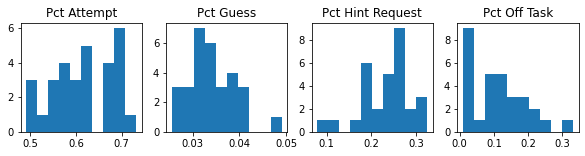

In [30]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Decisions EDA

In [31]:
# Get Learner actions
decisions = pd.DataFrame(db.decisions.find())
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

,_id,student_id,choice,time,action_evs,pev,problem,step,kc,learner_knowledge,attempt,hints_avail,hints_used,learner_off_task,self_eff,kcid
0,e830b049-c15c-4a4b-a088-a5f4ff065bbe,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,HintRequest,2020-10-20 11:44:53.570,"{'Attempt': 6.350554908863292, 'Guess': 0.6665...","[0.49534535846976424, 0.05199496677609582, 0.3...",3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,0aab6bd6-0222-4933-916c-e541cf9bb39f,{'_id': '6ba8a56b-1cd5-4e39-a1e0-c46e5621b062'...,False,0,3,0,False,0.288104,6ba8a56b-1cd5-4e39-a1e0-c46e5621b062
1,79e84ff8-c81b-4af3-aae6-5ca8e27e623c,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,Attempt,2020-10-20 11:44:56.980,"{'Attempt': 11.58123572025451, 'Guess': 1.0304...","[0.6289026065255748, 0.05595714137560926, 0.27...",3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,0aab6bd6-0222-4933-916c-e541cf9bb39f,{'_id': '6ba8a56b-1cd5-4e39-a1e0-c46e5621b062'...,True,1,2,1,False,0.288104,6ba8a56b-1cd5-4e39-a1e0-c46e5621b062
2,80d8c837-89cf-4c76-92e9-06058053987b,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,Attempt,2020-10-20 11:45:00.885,"{'Attempt': 6.366231274931398, 'Guess': 0.8712...","[0.4881784427568052, 0.06680971263460891, 0.38...",3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,8ca54f40-a33d-4fe9-a085-ce82e5f367cb,{'_id': '311a6cce-0ede-489b-971f-f21651d6ef2f'...,False,0,3,0,False,0.288815,311a6cce-0ede-489b-971f-f21651d6ef2f
3,5e49f213-9264-419c-aab0-650690f5a08d,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,HintRequest,2020-10-20 11:45:03.632,"{'Attempt': 6.381876350847671, 'Guess': 0.9031...","[0.4876020604894832, 0.06900116318770638, 0.38...",3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,{'_id': '20ee043d-ddb6-4b94-8fe6-6e79749ced21'...,False,0,3,0,False,0.289525,20ee043d-ddb6-4b94-8fe6-6e79749ced21
4,ae7ff9f5-c34c-40df-b505-c82a822b5b08,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,OffTask,2020-10-20 11:45:07.749,"{'Attempt': 11.60211668157743, 'Guess': 0.5945...","[0.6445624574246483, 0.033031507902714564, 0.2...",3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,{'_id': '20ee043d-ddb6-4b94-8fe6-6e79749ced21'...,True,1,2,1,False,0.289525,20ee043d-ddb6-4b94-8fe6-6e79749ced21


In [32]:
decisions[['problem', 'step', 'kcid', 'learner_knowledge', 'choice']].head(20)

,problem,step,kcid,learner_knowledge,choice
0,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,0aab6bd6-0222-4933-916c-e541cf9bb39f,6ba8a56b-1cd5-4e39-a1e0-c46e5621b062,False,HintRequest
1,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,0aab6bd6-0222-4933-916c-e541cf9bb39f,6ba8a56b-1cd5-4e39-a1e0-c46e5621b062,True,Attempt
2,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,8ca54f40-a33d-4fe9-a085-ce82e5f367cb,311a6cce-0ede-489b-971f-f21651d6ef2f,False,Attempt
3,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,20ee043d-ddb6-4b94-8fe6-6e79749ced21,False,HintRequest
4,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,20ee043d-ddb6-4b94-8fe6-6e79749ced21,True,OffTask
5,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,20ee043d-ddb6-4b94-8fe6-6e79749ced21,True,Attempt
6,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,9ba37300-613e-40ca-8e0f-daf4363ad612,98f7fd8d-2906-4161-b52b-24d4e5ed99ba,False,Attempt
7,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,9ba37300-613e-40ca-8e0f-daf4363ad612,98f7fd8d-2906-4161-b52b-24d4e5ed99ba,False,Attempt
8,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,9ba37300-613e-40ca-8e0f-daf4363ad612,98f7fd8d-2906-4161-b52b-24d4e5ed99ba,False,HintRequest
9,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,9ba37300-613e-40ca-8e0f-daf4363ad612,98f7fd8d-2906-4161-b52b-24d4e5ed99ba,False,Attempt


In [33]:
print(decisions['kc'][0])
print(decisions['action_evs'][0])
print(decisions['pev'][0])

{'_id': '6ba8a56b-1cd5-4e39-a1e0-c46e5621b062', 'domain_id': '59e60c39-debb-443b-b819-4607aa7dae27', 'pl0': 0.01, 'pt': 0.5830448546263165, 'ps': 0.21165485677492402, 'pg': 0.371266348935785, 'm_time': 4.937173766014507, 'sd_time': 1.2342934415036269}
{'Attempt': 6.350554908863292, 'Guess': 0.6665993449826062, 'HintRequest': 5.010522915695952, 'OffTask': 0.7927819309160965}
[0.49534535846976424, 0.05199496677609582, 0.3908224250344495, 0.06183724971969049]


In [34]:
decision_kc_stats = decisions.groupby(['student_id', 'kcid'])['learner_knowledge'].agg(['count', 'sum'])
decision_kc_stats.head(50)

count  \
student_id                           kcid                                          
04005938-ef42-47a7-b2fe-70341074ec9f 006ccb70-2de8-4ece-9522-20e24f0a89d5     21   
                                     007332b1-c342-4307-9cab-5c0cf85eb0cf     11   
                                     0088ef93-6238-4f86-b036-4e48341244df     22   
                                     00cbe5aa-c252-45cf-92ca-95897d5d5330     37   
                                     016d161c-4917-444a-a9db-5527df47c9c9     10   
                                     02097c21-71ff-468c-bd08-1c3fbd7c0862      6   
                                     027b849c-f583-4e13-9601-07a3bb2116a3     12   
                                     029f95bb-3b03-49c1-a398-25e850aa6a20     21   
                                     02c69512-7f33-4385-b8ef-d5af7b77c8a0     16   
                                     02f08a7e-767b-4a58-aca3-176ea35e30c1     20   
                                     0317fe57-a498-487d-ae16-a3f84ac5f0b4     22   
                                     035de061-5154-4293-919a-68c1ad40f9d6     35   
                                     03c3ec5d-cf5d-40d4-aed5-cbdfa8dde91d     19   
                                     0411bbac-2705-4bd7-84df-fb02e7719c83     15   
                                     0465b3fc-d501-4f8f-8223-e40a4f554b37     23   
                                     0476dbba-13d8-41fb-8e9f-515bb22110ff     39   
                                     047906af-e321-4876-aa94-49f8da5edf69     22   
                                     060db4c1-45ae-4351-bacf-dd57ac4832d5     14   
                                     06226619-5123-49f3-bd6b-dc033ca733b8     13   
                                     068c5c14-6b8a-4d32-90cf-278ba4a10006     19   
                                     06935543-50d2-44ea-ad0f-b4f60e0f19ba     17   
                                     06bc1b3e-bd95-48f5-981a-50e27fa337e6      9   
                                     06c81478-ee2b-496d-b96f-372b22b86b89      8   
                                     07cbf6b2-92e2-49b7-ae0e-0d4539de9f2a     23   
                                     0894a31b-d89d-42d5-b349-2a2b88089ed2     29   
                                     092453db-2dfa-4cda-a7e4-c17063647690      8   
                                     099c911e-1d00-4773-8da6-44a69c706f76     14   
                                     09dbe7e1-d6d2-4b20-be01-1119c7158e44     29   
                                     0a508e92-bdfc-42be-9fa8-3e9cac382bfd     39   
                                     0a68f9bb-719f-45d8-8fb0-7565076362d1     13   
                                     0b168310-a1a5-4af0-8a09-69e2c634f2f9     21   
                                     0b19bd7b-571f-4098-9ab6-cf9958f32bb0      9   
                                     0b6a3cbf-7da6-48f3-9a37-620db93f0064     54   
                                     0bd6dcfe-f9e8-4826-b866-43e0c418f052     27   
                                     0be648c7-037f-48ff-a465-092b004e3d60     62   
                                     0c302608-2c16-4f9e-bbab-d1ba958d9f60     18   
                                     0c5b511b-18ac-4511-8ea7-0a7df567142b     13   
                                     0c9d7c38-1f13-483d-96eb-ca87f77517af     11   
                                     0cb0706b-ff20-495d-a6f7-a5f8a1386c3c     19   
                                     0cc60841-5e6f-4e8a-945c-5f771b36d561     18   
                                     0ceac1e0-80a1-48ce-9132-d86c09533847     23   
                                     0d92af37-0144-4530-b5ba-c26bf7b423da     10   
                                     0e0177ed-436b-4ef3-9f18-28e7d912153c     13   
                                     0e197208-e17d-4024-ada9-7f4682e4b413      4   
                                     0e2dcc83-7dff-4db3-8d43-a83476b16619     20   
                                     0e4d2765-5950-499a-b68f-9755cc70a180      3   
                                     0ebaff

#### Learner Transactions EDA

In [35]:
# Get learner transactions
tx = pd.DataFrame(db.tutor_events.find({'type': "Tutor Input"}))
logger.info("Learner Transactions: %s" % str(tx.shape))
tx.head()

INFO:main:Learner Transactions: (421811, 17)


,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt
0,f8b78cf5-4796-4623-a4a0-ee43eae16ab2,Tutor Input,2020-10-20 11:44:56.980,50c7162d-e4a0-498f-9e87-e938b3f42520,037ec623-83d9-44f8-b915-10fb7225b8ce,2e1bf960-3e89-460e-98f9-fd0581210cd7,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,0aab6bd6-0222-4933-916c-e541cf9bb39f,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,3.410825,Hint,[{'_id': '6ba8a56b-1cd5-4e39-a1e0-c46e5621b062...,0.010000,0.584458,0,3,0
1,9f3d3c9a-97d6-440b-b750-b279bd921324,Tutor Input,2020-10-20 11:45:00.885,50c7162d-e4a0-498f-9e87-e938b3f42520,037ec623-83d9-44f8-b915-10fb7225b8ce,2e1bf960-3e89-460e-98f9-fd0581210cd7,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,0aab6bd6-0222-4933-916c-e541cf9bb39f,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,3.904269,Correct,[{'_id': '6ba8a56b-1cd5-4e39-a1e0-c46e5621b062...,0.584458,0.584458,1,2,1
2,1ad24be6-aaf9-4d80-af14-42b7899332b4,Tutor Input,2020-10-20 11:45:03.632,50c7162d-e4a0-498f-9e87-e938b3f42520,037ec623-83d9-44f8-b915-10fb7225b8ce,2e1bf960-3e89-460e-98f9-fd0581210cd7,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,8ca54f40-a33d-4fe9-a085-ce82e5f367cb,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,2.747086,Correct,[{'_id': '311a6cce-0ede-489b-971f-f21651d6ef2f...,0.160500,0.621861,0,3,0
3,134f997c-577a-4d03-a99c-189bd964162f,Tutor Input,2020-10-20 11:45:07.749,50c7162d-e4a0-498f-9e87-e938b3f42520,037ec623-83d9-44f8-b915-10fb7225b8ce,2e1bf960-3e89-460e-98f9-fd0581210cd7,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,4.117508,Hint,[{'_id': '20ee043d-ddb6-4b94-8fe6-6e79749ced21...,0.541409,0.726673,0,3,0
4,7308ab4e-bef0-48e4-a604-623d4d2f0a90,Tutor Input,2020-10-20 12:01:24.421,50c7162d-e4a0-498f-9e87-e938b3f42520,037ec623-83d9-44f8-b915-10fb7225b8ce,2e1bf960-3e89-460e-98f9-fd0581210cd7,3e4f9f56-c2ec-4f1e-8d1b-bf45b9bc5ade,fb32648f-f72c-43b7-bb74-376ea0c8e6e0,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,5.882064,Correct,[{'_id': '20ee043d-ddb6-4b94-8fe6-6e79749ced21...,0.726673,0.726673,1,2,1


In [36]:
# Add kc field that reduces list of kcs to 1 kc
tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)

In [37]:
# Aggregate Learner transaction stats

# Total Transaction counts
stu_stats = tx.groupby('stu_id').agg({'_id': 'count', 
                                      'duration': np.sum,
                                     })
stu_stats.rename(columns={'_id': "Total Tx",
                          'duration': 'Total Time'}, 
                         inplace = True)
stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
logger.info("Number of students: %i" % stu_stats.shape[0])
logger.info(stu_stats["Total Tx"].describe())

# Total of each outcome
d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot(index='stu_id', columns='outcome', values='_id')

# Prorporation of each outcome
stu_stats = pd.concat([stu_stats, d], axis=1)
stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']


logger.info(stu_stats.shape)

logger.info(stu_stats.columns)



INFO:main:Number of students: 30
INFO:main:count       30.000000
mean     14060.366667
std       3427.735992
min       8529.000000
25%      11659.000000
50%      12910.000000
75%      15531.250000
max      22326.000000
Name: Total Tx, dtype: float64
INFO:main:(30, 9)
INFO:main:Index(['Total Tx', 'Total Time', 'Total Time(hours)', 'Correct', 'Hint',
       'Incorrect', 'Pct Correct', 'Pct Hint', 'Pct Incorrect'],
      dtype='object')


In [38]:
# Attempts per step


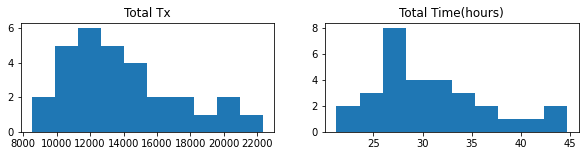

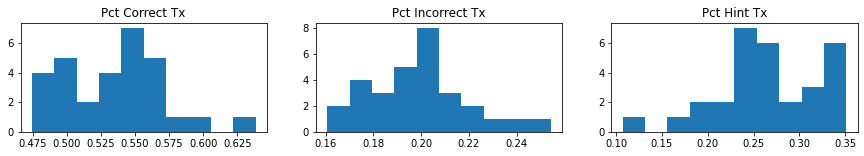

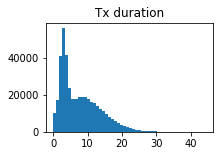

In [39]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

In [40]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

#prob_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id'])['duration'].count().reset_index()
#section_stats = step_stats.groupby(['stu_id', 'unit_id', 'section_id'])['sum'].agg(['count', np.mean, np.std])
#unit_stats = step_stats.groupby(['stu_id', 'unit_id'])['sum'].agg(['count', np.mean, np.std])


In [41]:
# Number of transactions with negative duration
# This is a sanity check
count = np.sum(tx['duration'] < 0)
logger.info("Number of transactions with negative duration: %i out of %i(%.2f%%)" % (count, tx.shape[0], count * 100 / tx.shape[0]))

INFO:main:Number of transactions with negative duration: 0 out of 421811(0.00%)


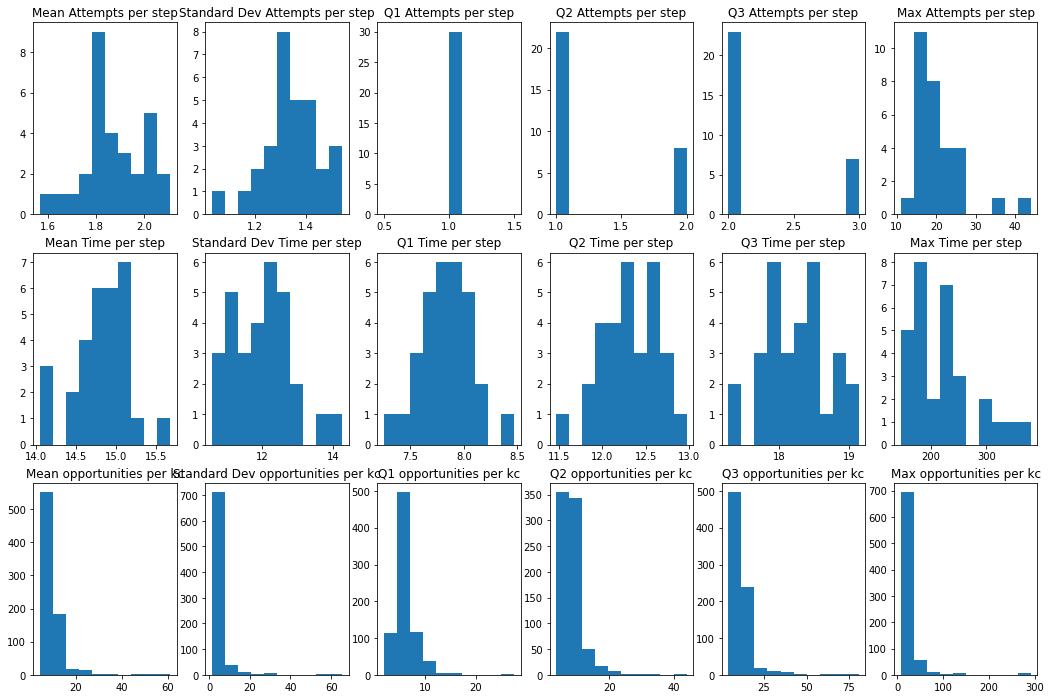

In [42]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Student to behavior EDA

In [52]:
# Merge behavioral stats with generated student measures
stus = pd.merge(sim_students, stu_stats, how='inner', left_on='_id', right_on=stu_stats.index)
logger.debug(stus.shape)
stus = pd.merge(stus, action_dist, how='inner', left_on='_id', right_on=action_dist.index)
for col in stus['values'][0].keys():
    stus['%s value' % col]  = stus.apply(lambda x: x['values'][col], axis=1)
logger.debug(stus.shape)
stus.head()

,_id,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,diligence,self_eff,...,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task,attempt value,guess value,hint request value,off task value
0,68d24c12-cdbf-4ce2-952d-03fe5ea3bbe6,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,"{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': True,...",30,1200,3,1,2.107698,0.288104,...,505,13304,0.686560,0.038785,0.236696,0.037959,10.458139,7.956895,2.377249,0.792782
1,327ad706-e622-4654-971c-667b03286091,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,"{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': True,...",30,1200,3,1,2.339970,0.456831,...,259,16826,0.628729,0.029954,0.325924,0.015393,9.669975,7.926334,3.976042,0.408133
2,df529b19-c107-4b83-842c-327aaf5d766a,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,"{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': True,...",30,1200,3,1,2.135348,0.524265,...,2509,14897,0.603343,0.031886,0.196348,0.168423,10.602967,8.082402,2.517745,4.542417
3,0493f231-fcf9-4ade-9a81-5ad3994f7054,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': False...,30,1200,3,1,2.537093,0.769449,...,1811,14508,0.618762,0.025641,0.230769,0.124828,9.881879,8.294632,3.000240,3.855012
4,8ef3af58-d9f2-49cd-b5b3-472bb5b1c2f7,59e60c39-debb-443b-b819-4607aa7dae27,Self Efficacy Learner,{'cddf7859-c4fa-42b0-892b-2c85a27d41d8': False...,30,1200,3,1,2.739164,0.508867,...,1101,11942,0.685061,0.034333,0.188411,0.092196,9.703531,9.369589,1.928152,2.529507


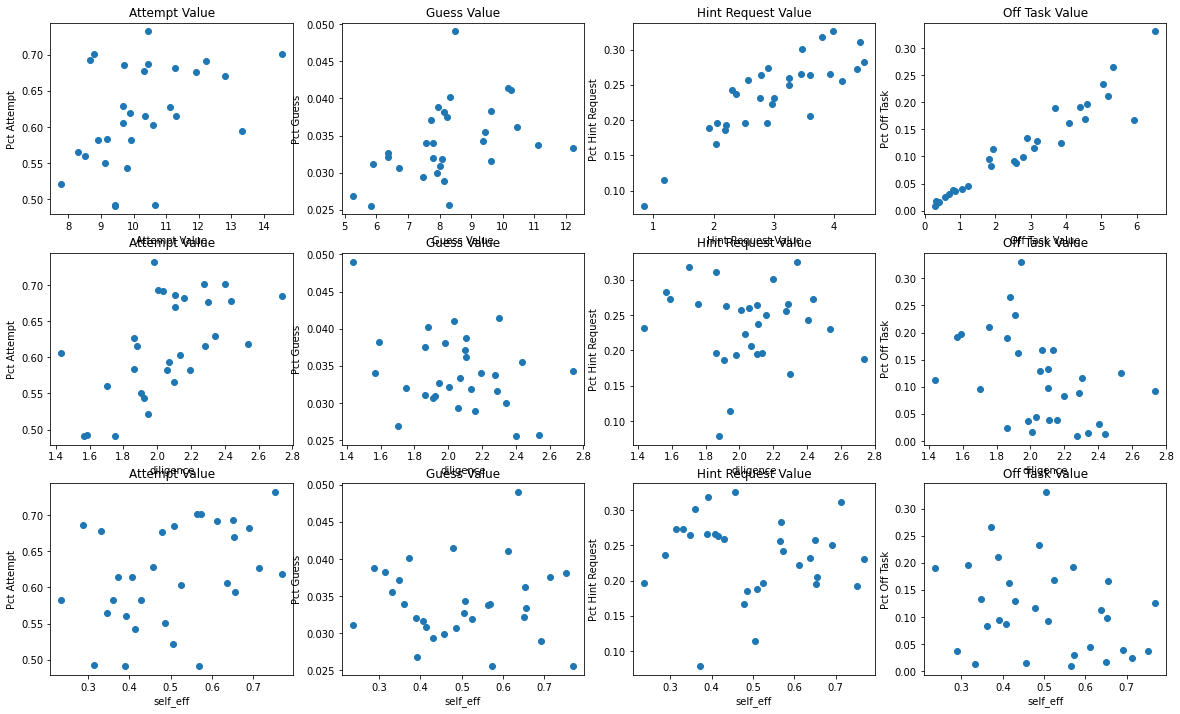

In [65]:
# Value vs action
num_bins = 10
num_rows = 3
num_cols = 4
row_height = 3
col_width = 5
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus['attempt value'], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel("Attempt Value")
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus['guess value'], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel("Guess Value")
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus['hint request value'], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel("Hint Request Value")
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus['off task value'], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel("Off Task Value")
plt.ylabel("Pct Off Task")

row = 1
xcol='diligence'
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus[xcol], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel(xcol)
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus[xcol], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel(xcol)
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus[xcol], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel(xcol)
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus[xcol], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel(xcol)
plt.ylabel("Pct Off Task")

row = 2
xcol='self_eff'
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus[xcol], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel(xcol)
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus[xcol], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel(xcol)
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus[xcol], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel(xcol)
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus[xcol], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel(xcol)
plt.ylabel("Pct Off Task")


plt.show()


In [53]:
for col in stus.columns:
    print(col)

_id
domain_id
type
skills
min_off_task
max_off_task
mean_guess_time
sd_guess_time
diligence
self_eff
values
total_attempts
total_success
final skills
final total attempts
final total success
pre-sim total mastery
final-sim total mastery
total skills
pre-sim pct mastery
final-sim pct mastery
final-sim total unmastered
final self-eff
pct success
Total Tx
Total Time
Total Time(hours)
Correct
Hint
Incorrect
Pct Correct
Pct Hint
Pct Incorrect
Attempt
Guess
Hint Request
Off Task
total
Pct Attempt
Pct Guess
Pct Hint Request
Pct Off Task
attempt value
guess value
hint request value
off task value


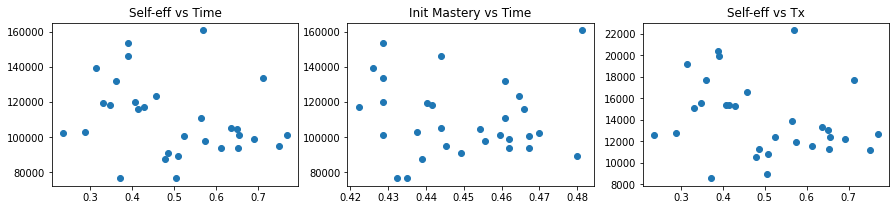

In [72]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.scatter(stus['self_eff'], stus['Total Time'])
plt.title("Self-eff vs Time")

plt.subplot(1,3,2)
plt.scatter(stus['pre-sim pct mastery'], stus['Total Time'])
plt.title("Init Mastery vs Time")


plt.subplot(1,3,3)
plt.scatter(stus['self_eff'], stus['Total Tx'])
plt.title("Self-eff vs Tx")

plt.show()
